In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks
import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta']


##  Data reading

In [3]:
run         = 'Run51'
run_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run}"

nchannels       = 8
nevents_per_wvf = 500

samples_per_waveform = 752

event_header_bytes = 28
# event_header_bytes = 3036

# sample_binning = 1
sample_binning = 8e-9

nfiles = 50


In [4]:
# CHECK WAVEFORMS' SIZES
print_headers = False
# --- Example usage ---
if __name__ == "__main__":

    for file in os.listdir(run_dir)[:5]:
        if file.endswith(".bin"):
            file_path = os.path.join(run_dir, file)
        path = file_path

        waveforms, headers = parse_data.load_waveforms_until_eof(
            path,
            channels=nchannels,
            samples_per_waveform=samples_per_waveform,
            dtype="<f4",
            event_header_bytes=event_header_bytes,  # set to 0 if no per-event header
        )

        print("Waveforms shape:", waveforms.shape)  # (num_events, 4, 500)
        if print_headers:
            if headers is not None:
                print("Headers shape:", headers.shape)   # (num_events, 7) for 28 bytes
                print("First header:", headers[0])


Waveforms shape: (500, 8, 752)
Waveforms shape: (500, 8, 752)
Waveforms shape: (500, 8, 752)


In [5]:

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_dir)[:nfiles],desc="Reading .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_dir, file)
        # print(file_path)
        df = parse_data.parse_wf_from_binary(file_path, 
                                             channels = nchannels, 
                                             n_events = nevents_per_wvf,
                                             file_idx = i,
                                             event_header_bytes = event_header_bytes,
                                             sample_binning = sample_binning
                                             )  
        dataframes.append(df)

Reading .bin files: 100%|██████████| 3/3 [00:05<00:00,  1.89s/file]


In [6]:
# Merge all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

In [7]:
df = merged_df
df.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,event,event_time,file_idx
1127995,0.000006,-370.237427,-388.038025,-411.613342,-485.535767,-350.281403,-443.881409,-407.960846,-454.385620,1499,94693497811,2
1127996,0.000006,-370.114563,-408.354492,-411.183258,-471.489838,-349.729187,-469.335419,-408.022369,-458.926392,1499,94693497811,2
1127997,0.000006,-370.913269,-429.959900,-411.183258,-450.574249,-349.422424,-493.501404,-408.699005,-460.767273,1499,94693497811,2
1127998,0.000006,-371.404785,-455.739075,-410.691681,-428.309296,-349.361053,-513.864624,-408.391449,-458.067322,1499,94693497811,2
1127999,0.000006,-370.913269,-490.540955,-410.998901,-411.748566,-349.729187,-526.867676,-408.268433,-452.176575,1499,94693497811,2


##  Data selection

In [8]:
# Filter for a specific event (change index as needed)
event_list  = df['event'].unique()
nevents     = len(event_list)
print(f'Unfiltered df nevents = {nevents}')

Unfiltered df nevents = 1500


In [9]:
if nchannels == 5:
    Amp_channels    = ['CH2', 'CH3', 'CH4', 'CH5'] # Amp
    noAmp_channels  = [] # noAmp

elif nchannels == 8:
    Amp_channels    = ['CH2', 'CH4', 'CH6', 'CH8'] # Amp
    noAmp_channels  = ['CH1', 'CH3', 'CH5', 'CH7'] # noAmp

elif nchannels == 9:
    Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9'] # Amp
    noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8'] # noAmp

elif nchannels == 10:
    Amp_channels    = ['CH4', 'CH6', 'CH8', 'CH10'] # Amp
    noAmp_channels  = ['CH3', 'CH5', 'CH7', 'CH9'] # noAmp


all_channels    = noAmp_channels + Amp_channels


##  Baseline determination

In [10]:
selected_ev = 200

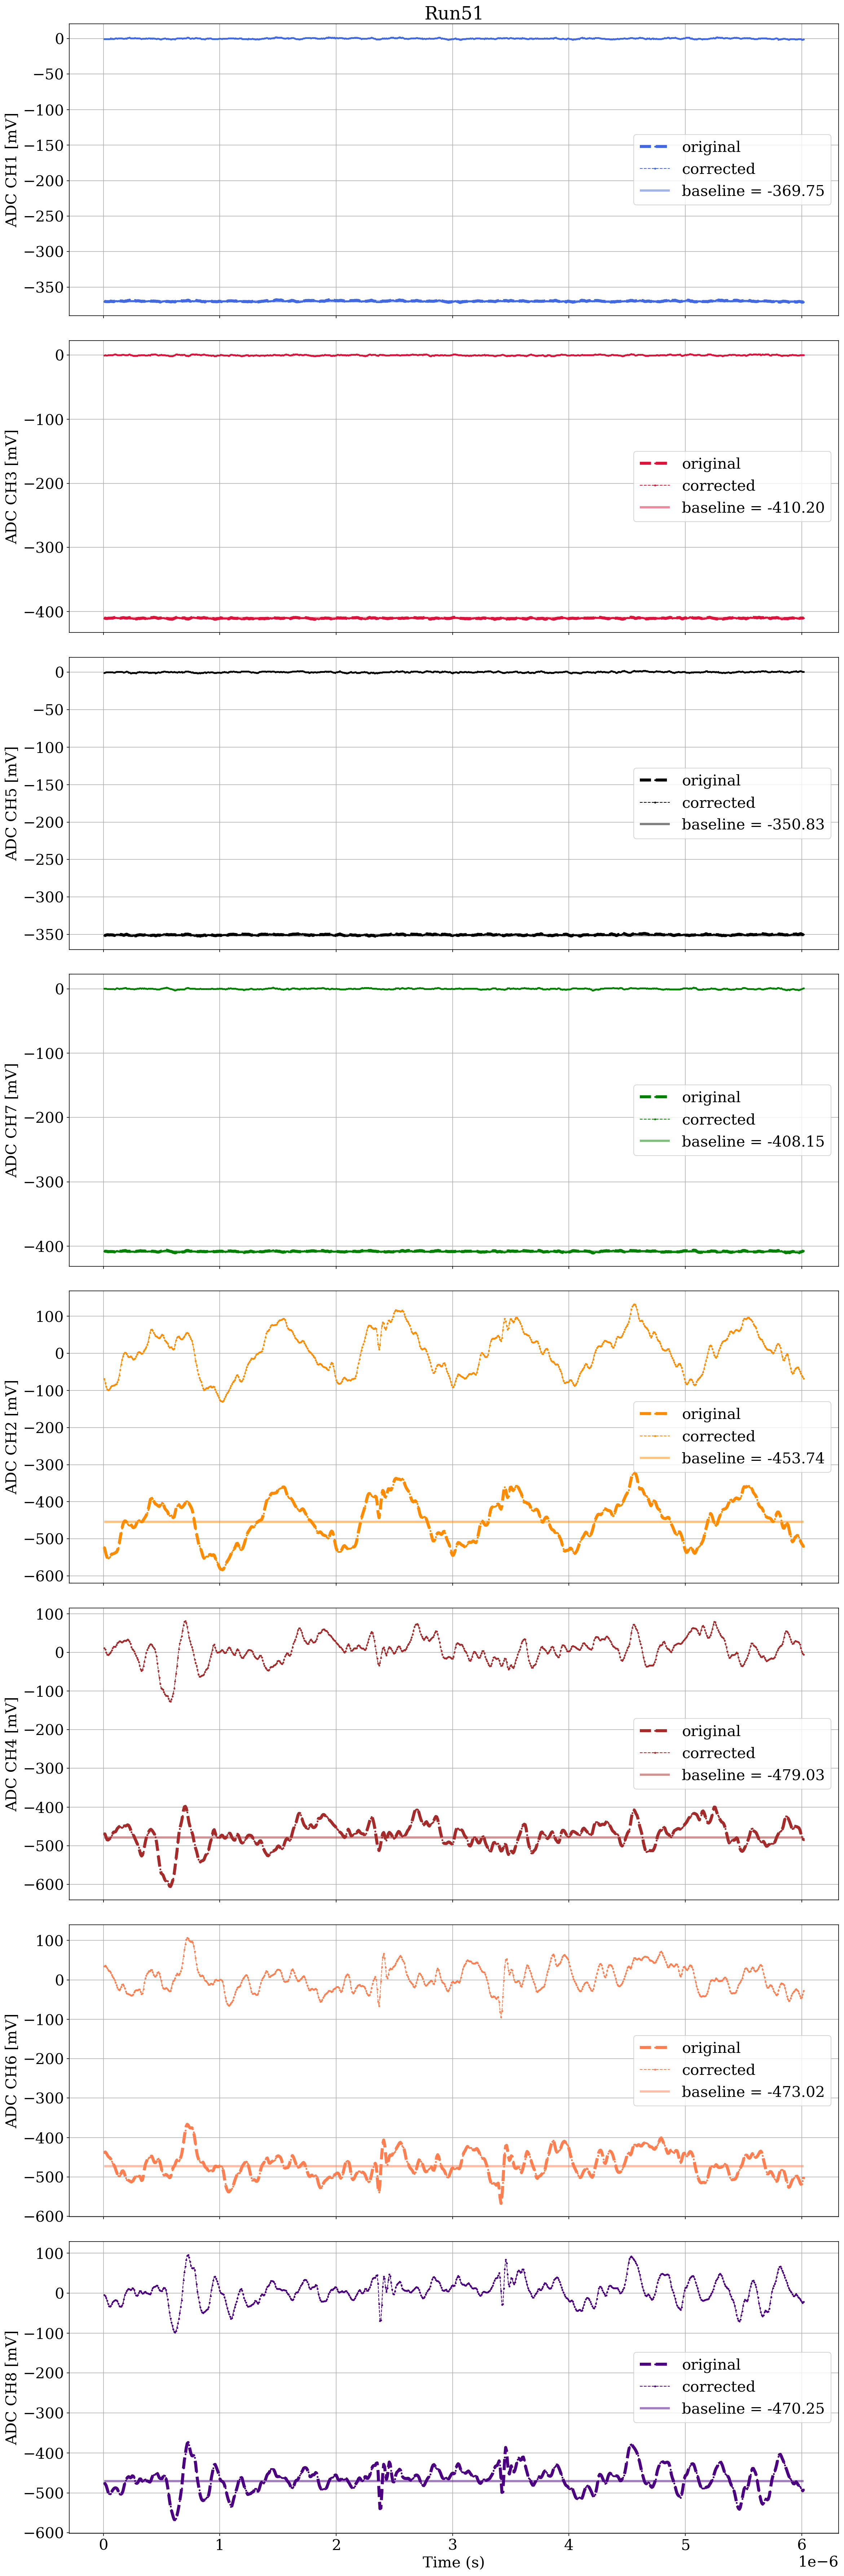

In [11]:
# Create subplots: 2 rows, 1 column

if len(all_channels) > 1:
    fig, axs = plt.subplots(len(all_channels), 1, figsize=(16, len(all_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(all_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = df['TIME'].values

# Plot CHs
for i, ch in enumerate(all_channels):

    if len(all_channels) > 1:
        ax = axs[i]

    voltage = df[f'{all_channels[i]}'].values

    t_matrix = time.reshape(nevents, -1)
    v_matrix = voltage.reshape(nevents, -1)
    v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix)

    ax.plot(t_matrix[selected_ev], v_matrix[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=4, label=f'original')
    ax.plot(t_matrix[selected_ev], v_matrix_corrected[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'corrected')
    

    # start = max(window[selected_ev], 0)
    # end   = min(window[selected_ev] + window_width, len(v_matrix[0]))
    # ax.fill_between(time[start:end], 
    #                 min(v_matrix_corrected[selected_ev].min(), v_matrix[selected_ev].min()), 
    #                 max(v_matrix_corrected[selected_ev].max(), v_matrix[selected_ev].max()), 
    #                 color = colors[i], alpha = 0.3)

    ax.hlines(baselines[selected_ev], t_matrix[selected_ev].min(), t_matrix[selected_ev].max(), 
              color= colors[i],
              linewidth=3,
              alpha = 0.5,
              label = f'baseline = {baselines[selected_ev]:.2f}'
              )

    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

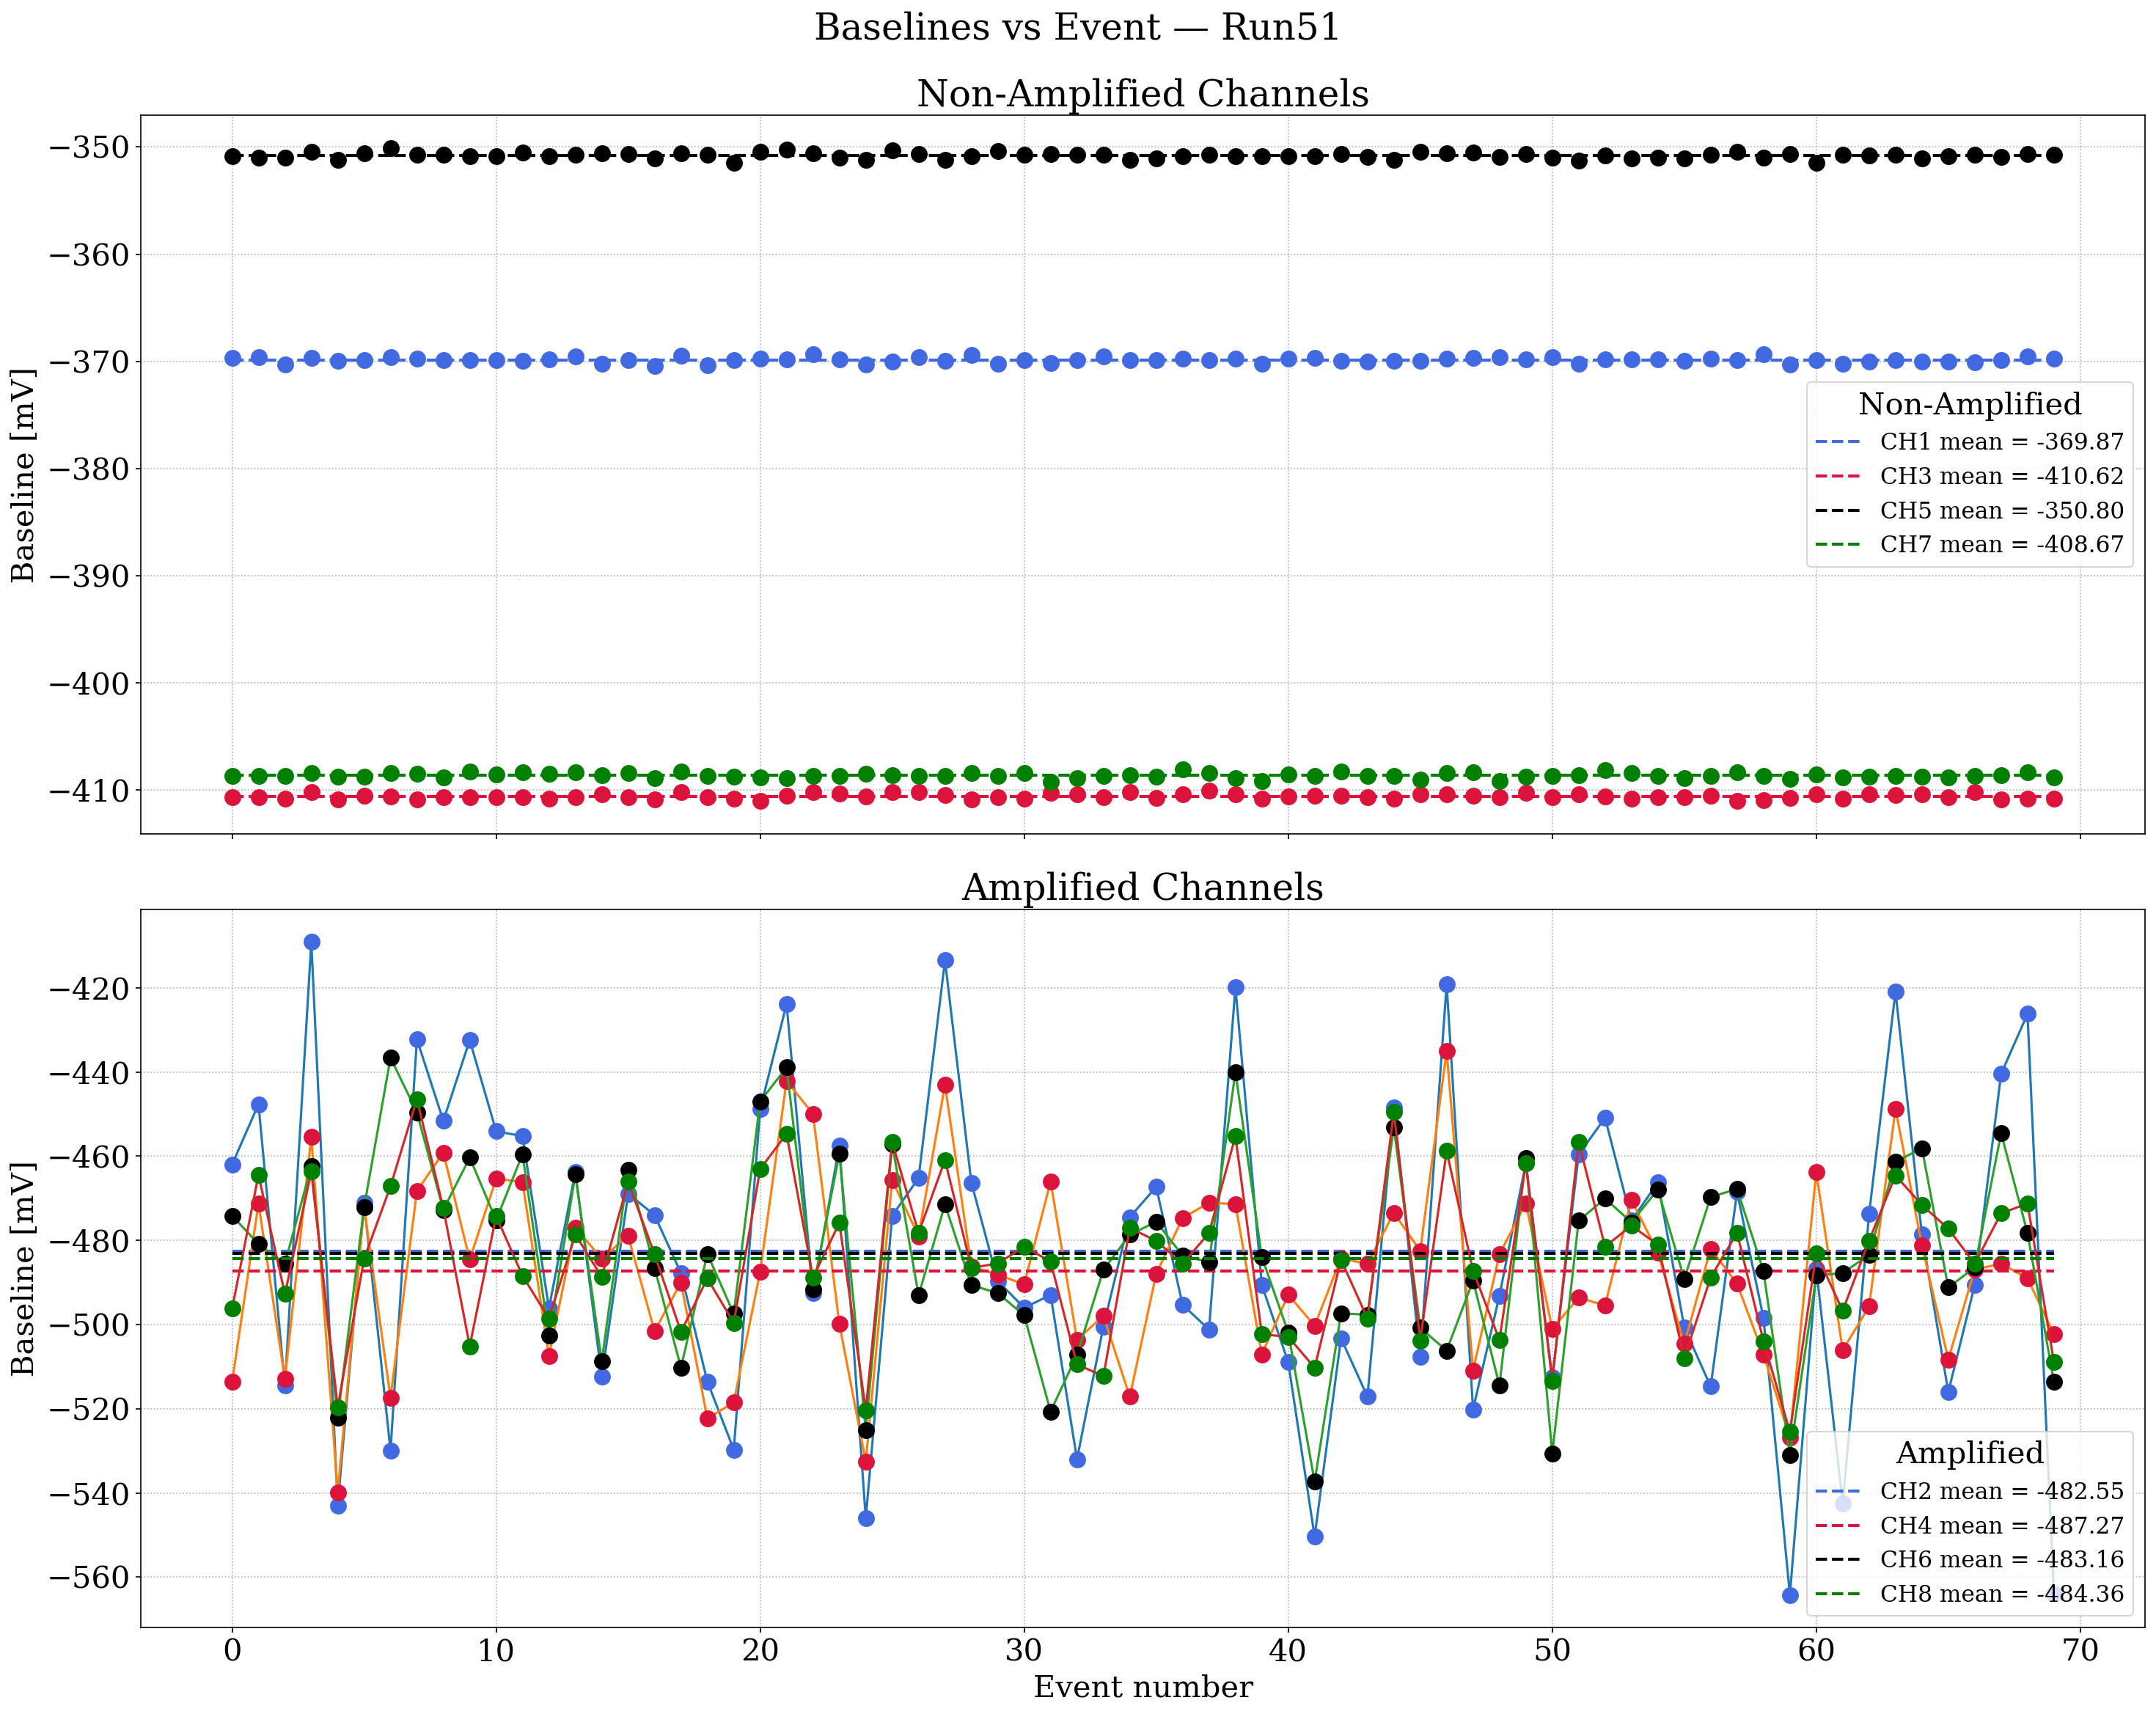

: 

In [ ]:
selected_nevents = 70
event_numbers = np.arange(selected_nevents)

# Create figure with 2 subplots, shared X axis
fig, (ax_nonamp, ax_amp) = plt.subplots(2, 1, figsize=(20, 16), dpi=150, sharex=True)

fig.suptitle(f"Baselines vs Event — {run}")

# ----------------------------------------
# 1) NON-AMPLIFIED SUBPLOT
# ----------------------------------------
ax_nonamp.set_title("Non-Amplified Channels")
ax_nonamp.set_ylabel("Baseline [mV]")
ax_nonamp.grid(True, linestyle=':')

for i, ch in enumerate(noAmp_channels):
    # get color index consistent with all channels
    color = colors[i]

    voltage = df[f'{ch}'].values
    t = df['TIME'].values

    # reshape to (events, samples)
    t_matrix = t.reshape(nevents, -1)[:selected_nevents]
    v_matrix = voltage.reshape(nevents, -1)[:selected_nevents]

    # baselines over all events
    v_corr, baselines, window = cig.BaselineCorrection(v_matrix)

    # scatter
    ax_nonamp.plot(
        event_numbers,
        baselines,
        linestyle="",
        marker="o",
        markersize=10,
        markerfacecolor=color,     # filled
        markeredgecolor=color,
    )

    # mean line
    mean_val = baselines.mean()
    ax_nonamp.hlines(
        mean_val,
        xmin=0,
        xmax=selected_nevents - 1,
        color=color,
        linestyles="--",
        linewidth=2,
        label=f"{ch} mean = {mean_val:.2f}"
    )

ax_nonamp.legend(title="Non-Amplified", fontsize = 15)


# ----------------------------------------
# 2) AMPLIFIED SUBPLOT
# ----------------------------------------
ax_amp.set_title("Amplified Channels")
ax_amp.set_xlabel("Event number")
ax_amp.set_ylabel("Baseline [mV]")
ax_amp.grid(True, linestyle=':')

for i, ch in enumerate(Amp_channels):
    color = colors[i]

    voltage = df[f'{ch}'].values
    t = df['TIME'].values

    t_matrix = t.reshape(nevents, -1)[:selected_nevents]
    v_matrix = voltage.reshape(nevents, -1)[:selected_nevents]

    v_corr, baselines, window = cig.BaselineCorrection(v_matrix)

    # scatter
    ax_amp.plot(
        event_numbers,
        baselines,
        linestyle="-",
        marker="o",
        markersize=10,
        # markerfacecolor="none",    # empty
        markerfacecolor=color,    
        markeredgecolor=color,
    )

    # mean line
    mean_val = baselines.mean()
    ax_amp.hlines(
        mean_val,
        xmin=0,
        xmax=selected_nevents - 1,
        color=color,
        linestyles="--",
        linewidth=2,
        label=f"{ch} mean = {mean_val:.2f}"
    )

ax_amp.legend(title="Amplified", fontsize = 15)


# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.show()
